# MFD engines

This tutorial details the trip-based MFD engines provided by the packages MnMs. It focuses on the tools MFDFlow and MFDFlowEvent to compute the travel times. The example features two users in a two-mode two-reservoir setting.

## Design of a graph

In [1]:
from mnms.graph.core import MultiModalGraph
from mnms.mobility_service.base import BaseMobilityService

mmgraph = MultiModalGraph()
flow_graph = mmgraph.flow_graph

flow_graph.add_node('0', [0, 0])
flow_graph.add_node('1', [0, 40000])
flow_graph.add_node('2', [1200, 0])
flow_graph.add_node('3', [1400, 0])
flow_graph.add_node('4', [3400, 0])

flow_graph.add_link('0_1', '0', '1')
flow_graph.add_link('0_2', '0', '2')
flow_graph.add_link('2_3', '2', '3')
flow_graph.add_link('3_4', '3', '4')

# Define the two reservoirs in the graph
mmgraph.add_zone('res1', ['0_1', '0_2', '2_3'])
mmgraph.add_zone('res2', ['3_4'])

car = BaseMobilityService('car', 10)
car.add_node('C0', '0')
car.add_node('C1', '1')
car.add_node('C2', '2')

car.add_link('C0_C1', 'C0', 'C1', costs={'length':40000}, reference_links=['0_1'])
car.add_link('C0_C2', 'C0', 'C2', costs={'length':1200}, reference_links=['0_2'])

bus = BaseMobilityService('bus', 10)
bus.add_node('B2', '2')
bus.add_node('B3', '3')
bus.add_node('B4', '4')

bus.add_link('B2_B3', 'B2', 'B3', costs={'length':200}, reference_links=['2_3'])
bus.add_link('B3_B4', 'B3', 'B4', costs={'length':2000}, reference_links=['3_4'])

mmgraph.add_mobility_service(bus)
mmgraph.add_mobility_service(car)

mmgraph.connect_mobility_service('CAR_BUS', 'C2', 'B2', costs={'length':0, 'time':0})


## Design of the two reservoirs

In [2]:
from mnms.flow.MFD import Reservoir

# Define the traffic dynamics of the two reservoirs
def res_fct1(dict_accumulations):
            v_car = 10 * (1 - (dict_accumulations['car'] + 2*dict_accumulations['bus']) / 80)
            v_car = max(v_car, 0.001)
            v_bus = v_car / 2
            dict_speeds = {'car': v_car, 'bus': v_bus}
            return dict_speeds

def res_fct2(dict_accumulations):
    v_car = 12 * (1 - (dict_accumulations['car'] + dict_accumulations['bus']) / 50)
    v_car = max(v_car, 0.001)
    v_bus = v_car / 3
    dict_speeds = {'car': v_car, 'bus': v_bus}
    return dict_speeds

res1 = Reservoir('res1', ['car', 'bus'], res_fct1)
res2 = Reservoir('res2', ['car', 'bus'], res_fct2)


## Create users and affect a path

In [3]:
from mnms.demand.user import User
from mnms.graph.shortest_path import compute_shortest_path
from mnms.tools.time import Time, Dt

user1 = User('1', '0', '4', Time.fromSeconds(100), scale_factor=2)
user2 = User('2', '0', '1', Time.fromSeconds(110), scale_factor=4)

compute_shortest_path(mmgraph, user1, cost='length')
compute_shortest_path(mmgraph, user2, cost='length')

40000

## Create the MFD Flow object

In [4]:
from mnms.flow.MFD import MFDFlow

mfd_flow = MFDFlow(outfile="results/flow_EnginesMFD.csv")
mfd_flow.add_reservoir(res1)
mfd_flow.add_reservoir(res2)
mfd_flow.set_graph(mmgraph)

## Run simulation

In [5]:
dt = Dt(seconds=30)
nb_steps = 100

mfd_flow.initialize()
mfd_flow._tcurrent = Time.fromSeconds(0)
for step in range(nb_steps):
    if mfd_flow._tcurrent < Time.fromSeconds(100) < mfd_flow._tcurrent.add_time(dt):
        mfd_flow.step(dt.to_seconds(), [user1, user2])
    else:
        mfd_flow.step(dt.to_seconds(), [])
    mfd_flow.update_time(dt)
    mfd_flow.write_result(step_affectation=0, step_flow=step)

## Create the MFD Flow Event object

In [6]:
from mnms.flow.MFD_event import MFDFlowEvent

mfd_flow_event = MFDFlowEvent(outfile="results/flow_EnginesMFD_event.csv")
res1 = Reservoir('res1', ['car', 'bus'], res_fct1)
res2 = Reservoir('res2', ['car', 'bus'], res_fct2)
mfd_flow_event.add_reservoir(res1)
mfd_flow_event.add_reservoir(res2)
mfd_flow_event.set_graph(mmgraph)

## Run event-based simulation

In [7]:
mfd_flow_event.initialize()
mfd_flow_event._tcurrent = Time.fromSeconds(0)
for step in range(nb_steps):
    if mfd_flow_event._tcurrent < Time.fromSeconds(100) < mfd_flow_event._tcurrent.add_time(dt):
        mfd_flow_event.step(dt, [user1, user2])
    else:
        mfd_flow_event.step(dt, [])
    mfd_flow_event.update_time(dt)
    mfd_flow_event.write_result(step_affectation=0, step_flow=step)

## Compare results

In [8]:
import pandas as pd

flow_result = pd.read_csv('results/flow_EnginesMFD.csv', sep=';')
flow_result_event = pd.read_csv('results/flow_EnginesMFD_event.csv', sep=';')

In [9]:
flow_result

,AFFECTATION_STEP,FLOW_STEP,TIME,RESERVOIR,MODE,SPEED,ACCUMULATION
0,0,0,00:00:30.00,res1,car,10.00,0
1,0,0,00:00:30.00,res1,bus,5.00,0
2,0,0,00:00:30.00,res2,car,12.00,0
3,0,0,00:00:30.00,res2,bus,4.00,0
4,0,1,00:01:00.00,res1,car,10.00,0
...,...,...,...,...,...,...,...
237,0,59,00:30:00.00,res1,bus,4.75,0
238,0,59,00:30:00.00,res2,car,12.00,0
239,0,59,00:30:00.00,res2,bus,4.00,0
240,0,60,00:30:30.00,res1,car,9.50,4


In [10]:
flow_result_bus1 = flow_result[(flow_result['MODE']=='bus') & (flow_result['RESERVOIR']=='res1')]
flow_result_bus1_event = flow_result_event[(flow_result_event['MODE']=='bus') & (flow_result_event['RESERVOIR']=='res1')]
flow_result_car1 = flow_result[(flow_result['MODE']=='car')& (flow_result['RESERVOIR']=='res1')]
flow_result_car1_event = flow_result_event[(flow_result_event['MODE']=='car')& (flow_result_event['RESERVOIR']=='res1')]

flow_result_bus2 = flow_result[(flow_result['MODE']=='bus') & (flow_result['RESERVOIR']=='res2')]
flow_result_bus2_event = flow_result_event[(flow_result_event['MODE']=='bus') & (flow_result_event['RESERVOIR']=='res2')]
flow_result_car2 = flow_result[(flow_result['MODE']=='car')& (flow_result['RESERVOIR']=='res2')]
flow_result_car2_event = flow_result_event[(flow_result_event['MODE']=='car')& (flow_result_event['RESERVOIR']=='res2')]

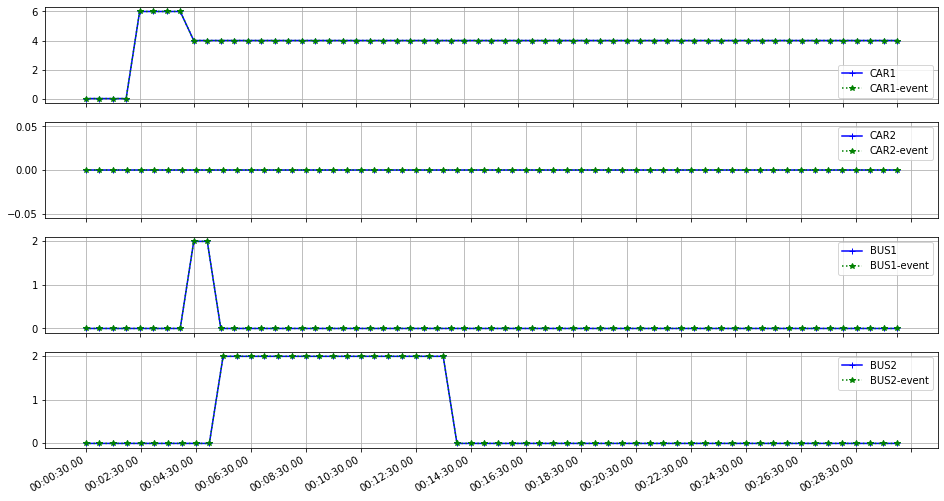

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(16, 9))

#ax.plot(flow_result_bus1['TIME'].to_list(), flow_result_bus1['ACCUMULATION'].to_list(), 'r+-', label='BUS1')
#ax.plot(flow_result_bus1_event['TIME'].to_list(), flow_result_bus1_event['ACCUMULATION'].to_list(), 'm*:', label='BUS1-event')
ax1.plot(flow_result_car1['TIME'].to_list(), flow_result_car1['ACCUMULATION'].to_list(), 'b+-', label='CAR1')
ax1.plot(flow_result_car1_event['TIME'].to_list(), flow_result_car1_event['ACCUMULATION'].to_list(), 'g*:', label='CAR1-event')
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
ax1.grid()
ax1.legend()

ax2.plot(flow_result_car2['TIME'].to_list(), flow_result_car2['ACCUMULATION'].to_list(), 'b+-', label='CAR2')
ax2.plot(flow_result_car2_event['TIME'].to_list(), flow_result_car2_event['ACCUMULATION'].to_list(), 'g*:', label='CAR2-event')
ax2.xaxis.set_major_locator(plt.MaxNLocator(20))
ax2.grid()
ax2.legend()

ax3.plot(flow_result_bus1['TIME'].to_list(), flow_result_bus1['ACCUMULATION'].to_list(), 'b+-', label='BUS1')
ax3.plot(flow_result_bus1_event['TIME'].to_list(), flow_result_bus1_event['ACCUMULATION'].to_list(), 'g*:', label='BUS1-event')
ax3.xaxis.set_major_locator(plt.MaxNLocator(20))
ax3.grid()
ax3.legend()

ax4.plot(flow_result_bus2['TIME'].to_list(), flow_result_bus2['ACCUMULATION'].to_list(), 'b+-', label='BUS2')
ax4.plot(flow_result_bus2_event['TIME'].to_list(), flow_result_bus2_event['ACCUMULATION'].to_list(), 'g*:', label='BUS2-event')
ax4.xaxis.set_major_locator(plt.MaxNLocator(20))
ax4.grid()
ax4.legend()
fig.autofmt_xdate()

In [12]:
dt.to_seconds()

30.0